In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)

dc_data <- read_excel("Data_User_Modeling_Dataset.xlsx", sheet = 2)

tidy_data <- dc_data |>
    select(STG, PEG, UNS) |>
    mutate(UNS = as_factor(UNS))


tidy_data



New names:
• `` -> `...7`
• `` -> `...8`


STG,PEG,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,very_low
0.08,0.90,High
0.06,0.33,Low
0.10,0.30,Middle
0.08,0.24,Low
0.09,0.66,Middle
0.10,0.56,Middle
0.15,0.01,very_low
0.20,0.25,Low


Now we will create a plot to see how the two variables relate to eachother


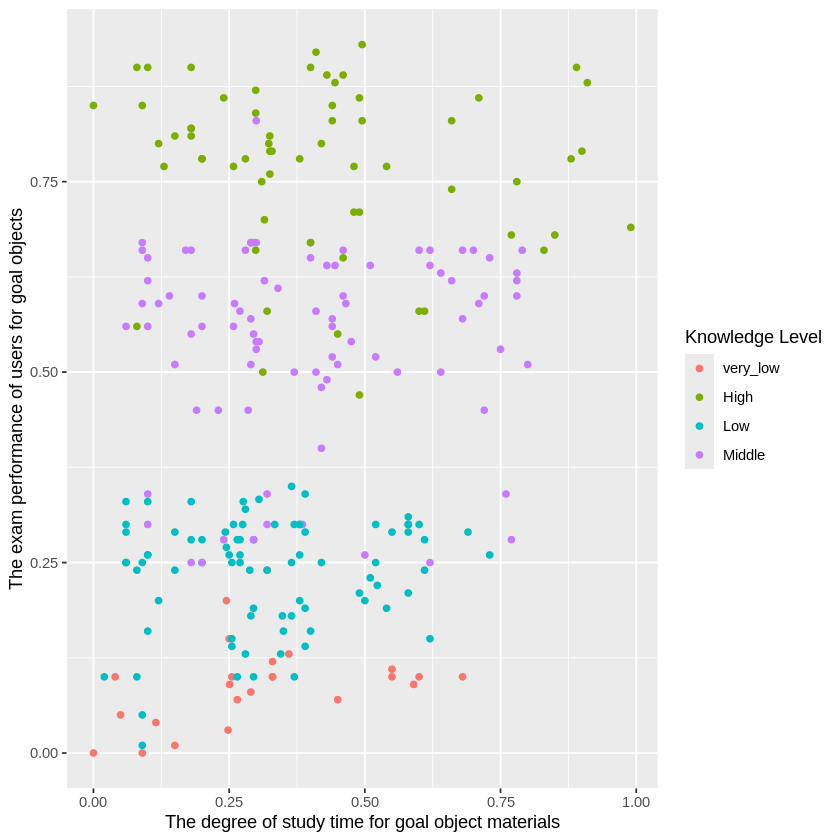

In [11]:
dc_plot <- tidy_data |>
    ggplot(aes(x=STG, y=PEG, color=UNS))+
    geom_point()+
    labs(x="The degree of study time for goal object materials", y="The exam performance of users for goal objects", color="Knowledge Level")

dc_plot

We Will now split the data into a training and testing set

In [13]:
dc_split <- initial_split(tidy_data, prop = 0.75, strata = UNS)  
dc_train <- training(dc_split)   
dc_test <- testing(dc_split)

We will now create a recipe and scale the data

In [14]:
dc_recipe <- recipe(UNS ~ STG + PEG , data = dc_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

We now create a specification for the model and our 5 vfold

In [17]:
dc_vfold <- vfold_cv(dc_train, v = 5, strata = UNS)

dc_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")


dc_results<- workflow() |>
       add_recipe(dc_recipe) |>
       add_model(dc_spec) |>
       tune_grid(resamples = dc_vfold, grid = 10) |>
       collect_metrics()

dc_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.7386842,5,0.031247161,Preprocessor1_Model1
2,roc_auc,hand_till,0.8672950,5,0.026978038,Preprocessor1_Model1
5,accuracy,multiclass,0.7757895,5,0.028711961,Preprocessor1_Model2
5,roc_auc,hand_till,0.9102071,5,0.008721875,Preprocessor1_Model2
6,accuracy,multiclass,0.7757895,5,0.028711961,Preprocessor1_Model3
6,roc_auc,hand_till,0.9168389,5,0.014099402,Preprocessor1_Model3
7,accuracy,multiclass,0.7652632,5,0.034776692,Preprocessor1_Model4
7,roc_auc,hand_till,0.9224325,5,0.014378441,Preprocessor1_Model4
9,accuracy,multiclass,0.7552632,5,0.035696474,Preprocessor1_Model5


We will now plot the accuracy of each value of K so we will know which to use as our predictor

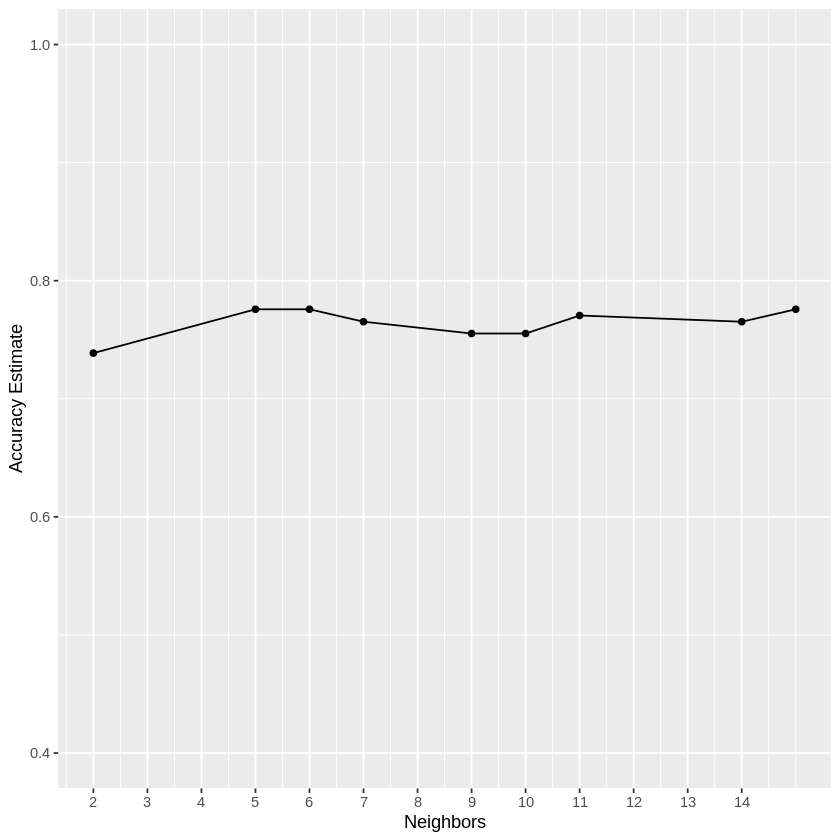

In [18]:
accuracies <- dc_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

 We can see that the best values of K are 5 and 6 with the same accuracy value, we will take 5 as our K to classify from now on

In [23]:
dc_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
       set_engine("kknn") |>
       set_mode("classification")

dc_final_fit <- workflow() |>
       add_recipe(dc_recipe) |>
       add_model(dc_final_spec) |>
       fit(data = dc_train)

In [24]:
dc_test_predictions <- predict(dc_final_fit , dc_test) |>
       bind_cols(dc_test)

dc_test_predictions

.pred_class,STG,PEG,UNS
<fct>,<dbl>,<dbl>,<fct>
Middle,0.100,0.560,Middle
Middle,0.200,0.600,Middle
Low,0.150,0.290,Low
Middle,0.200,0.560,Middle
Low,0.060,0.250,Low
High,0.090,0.850,High
Low,0.090,0.250,Low
Middle,0.080,0.560,High
High,0.150,0.810,High


In [25]:
dc_prediction_accuracy <- dc_test_predictions |>
         metrics(truth = UNS, estimate = .pred_class)

dc_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7727273
kap,multiclass,0.6796117


In [26]:
dc_mat <- dc_test_predictions |> 
       conf_mat(truth = UNS, estimate = .pred_class)


dc_mat

          Truth
Prediction very_low High Low Middle
  very_low        4    0   2      0
  High            0   10   0      0
  Low             2    0  19      3
  Middle          0    8   0     18

Bibliograpy

Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.